In [4]:
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
filename='./sms/SMSSpamCollection.txt'
with open(filename) as f:
    lines = f.readlines()

Let us use the NLP library nltk to help us tokenize and understand the data

In [5]:
label_set=[]
sms_set=[]

for i in range(0,len(lines)):
    token_list=word_tokenize(lines[i])
    label_set.append(token_list[0])
    sms_set.append(token_list[1:])

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(sms_set,label_set, test_size=0.1, random_state=42)

In [6]:
data=pd.DataFrame(data={'sms':X_train,'label':y_train})
data.head()

,sms,label
0,"[Amazing, :, If, you, rearrange, these, letter...",ham
1,"[Reverse, is, cheating, ., That, is, not, math...",ham
2,"[Hanging, out, with, my, brother, and, his, fa...",ham
3,"[Thanks, a, lot, for, your, wishes, on, my, bi...",ham
4,"[Check, Out, Choose, Your, Babe, Videos, @, sm...",spam


Group the text WRT to the label.

In [7]:
ham_tokens=[items for token_list in data.query("label == 'ham'").sms for items in token_list]
spam_tokens=[items for token_list in data.query("label == 'spam'").sms for items in token_list]

In [8]:
d1=nltk.FreqDist(ham_tokens)  #frequency of non-spam message
d2=nltk.FreqDist(spam_tokens) #frequency of spam message

d1_total = d1.N()
d1_pdf=d1.copy()
for word in d1:
    d1_pdf[word] /= float(d1_total)

d2_total = d2.N()
d2_pdf=d2.copy()
for word in d2:
    d2_pdf[word] /= float(d2_total)

print(d1_pdf.items())
print(d2_pdf.items())

dict_items([('Amazing', 3.9747207758654956e-05), (':', 0.006598036487936722), ('If', 0.0014441485485644633), ('you', 0.020377068510937107), ('rearrange', 1.3249069252884985e-05), ('these', 0.0001722379002875048), ('letters', 3.9747207758654956e-05), ('it', 0.006955761357764617), ('gives', 7.949441551730991e-05), ('the', 0.012268638128171496), ('same', 0.0004372192853452045), ('meaning', 9.27434847701949e-05), ('...', 0.01379228109225327), ('Dormitory', 1.3249069252884985e-05), ('=', 7.949441551730991e-05), ('Dirty', 1.3249069252884985e-05), ('room', 0.0004239702160923195), ('Astronomer', 1.3249069252884985e-05), ('Moon', 1.3249069252884985e-05), ('starer', 1.3249069252884985e-05), ('The', 0.000861189501437524), ('eyes', 7.949441551730991e-05), ('They', 0.00035772486982789457), ('see', 0.0014441485485644633), ('Election', 1.3249069252884985e-05), ('results', 2.649813850576997e-05), ('Lies', 1.3249069252884985e-05), ('lets', 7.949441551730991e-05), ('recount', 1.3249069252884985e-05), ('

In [9]:
DEBUG=0
def score(utterance):
    cumscore = 0
    NHAM = d1.N()
    NSPAM = d2.N()
    MAXSCORE = np.log(20) / np.log(2)
    MINSCORE_HAM = np.log( 0.1 / d1.N() ) / np.log(2)
    MINSCORE_SPAM = np.log( 0.1 / d2.N() ) / np.log(2)

    for token in nltk.word_tokenize(utterance):
        partialscore=0 
        if d1[token] != 0 and d2[token] != 0 and (d1[token]+d2[token]):
            partialscore = (np.log(d1[token]) - np.log(NHAM) -
                            np.log(d2[token])  + np.log(NSPAM))/np.log(2) #use log odds 
            partialscore = np.minimum(MAXSCORE, np.maximum(-MAXSCORE, partialscore))
            if DEBUG: 
                print(partialscore, d1[token], d2[token])
        if d1[token] == 0 and d2[token] > 0:
            partialscore = -MAXSCORE
        if d2[token] == 0 and d1[token]> 0 :
            partialscore = MAXSCORE
        if d2[token] == 0 and d1[token] == 0 :
            partialscore = MINSCORE_HAM - MINSCORE_SPAM 
        cumscore = cumscore + partialscore
    return(cumscore)

In [10]:
d1_score= [score(word) for word in d1.keys()] 
d2_score = [score(word) for word in d2.keys()] 

Histogram of the scores of each word (labeled by spam or not).

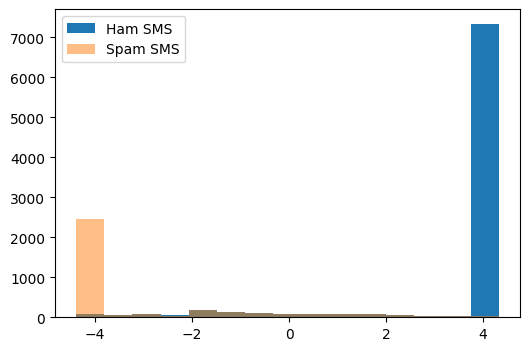

In [11]:
fig=plt.subplots(figsize=(6,4))
plt.hist(d1_score, bins=15,label='Ham SMS')
plt.hist(d2_score, bins=15, alpha=0.5,label='Spam SMS')
plt.legend()
plt.show()

In [12]:
print(score("How's it going my guy"))
print(score("Our records show you overpaid for (a product or service). Kindly supply your bank routing and account number to receive your refund"))

18.87400559696769
-14.486161505605942


Now we can put together our training dataset by mapping the classifier labels to 0 or 1 and include a new column that contains the score of each message.

In [13]:
DEBUG=0
def score(utterance):
    cumscore = 0
    NHAM = d1.N()
    NSPAM = d2.N()
    MAXSCORE = np.log(20) / np.log(2)
    MINSCORE_HAM = np.log( 0.1 / d1.N() ) / np.log(2)
    MINSCORE_SPAM = np.log( 0.1 / d2.N() ) / np.log(2)

    for token in utterance:
        partialscore=0 
        if d1[token] != 0 and d2[token] != 0 and (d1[token]+d2[token]):
            partialscore = (np.log(d1[token]) - np.log(NHAM) -
                            np.log(d2[token])  + np.log(NSPAM))/np.log(2) #use log odds 
            partialscore = np.minimum(MAXSCORE, np.maximum(-MAXSCORE, partialscore))
            if DEBUG: 
                print(partialscore, d1[token], d2[token])
        if d1[token] == 0 and d2[token] > 0:
            partialscore = -MAXSCORE
        if d2[token] == 0 and d1[token]> 0 :
            partialscore = MAXSCORE
        if d2[token] == 0 and d1[token] == 0 :
            partialscore = MINSCORE_HAM - MINSCORE_SPAM 
        cumscore = cumscore + partialscore
    return(cumscore)

In [14]:
data['label']=data['label'].map({'ham':1, 'spam':0})
data['score']=data.apply(lambda row: score(row.sms), axis=1)
data.head()

,sms,label,score
0,"[Amazing, :, If, you, rearrange, these, letter...",1,99.428468
1,"[Reverse, is, cheating, ., That, is, not, math...",1,19.095353
2,"[Hanging, out, with, my, brother, and, his, fa...",1,20.640099
3,"[Thanks, a, lot, for, your, wishes, on, my, bi...",1,27.828761
4,"[Check, Out, Choose, Your, Babe, Videos, @, sm...",0,-33.289060


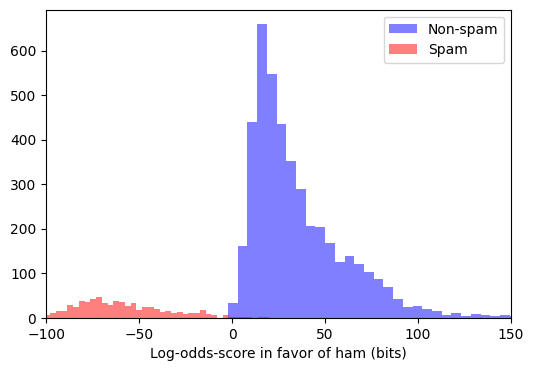

In [15]:
plt.subplots(figsize=(6,4))

plt.hist(data.query("label==1")['score'], bins=100, color="blue", alpha=0.5, label="Non-spam")
plt.hist(data.query("label==0")['score'], bins=40, color="red", alpha=0.5, label="Spam")
plt.xlabel("Log-odds-score in favor of ham (bits)")
plt.xlim(-100, 150)
plt.legend()

Let's test with the remaining testing dataset.

In [16]:
def exp2(num):
    return np.power(2,num)
def p(odds):
    return odds / (1+odds)

def classifier(sms,label):
    df=pd.DataFrame(data={'sms':sms,'label':label})

    df['pred']=df.apply(lambda row:round(p(exp2(score(row.sms)))),axis=1)
    df['label']=df['label'].map({'ham':1, 'spam':0})

    df_confusion = pd.crosstab(df['label'], df['pred'])

    return df_confusion

<AxesSubplot:xlabel='pred', ylabel='label'>

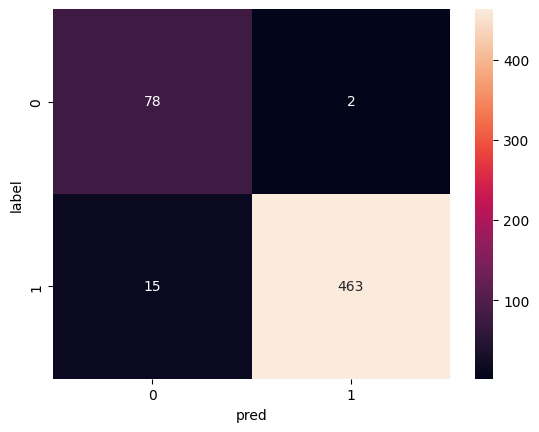

In [17]:
import seaborn as sns
df_confusion=classifier(X_test,y_test)

ax= plt.subplot()
sns.heatmap(df_confusion, annot=True, fmt='g', ax=ax)

Lets test this on a new dataset of spam sms.

In [18]:
filename='./sms/Testing.csv'
with open(filename) as f:
    testing = f.readlines()

label_set=[]
sms_set=[]

for i in range(1,len(testing)):
    token_list=word_tokenize(testing[i])
    label_set.append(token_list[0])
    sms_set.append(token_list[2:]) #starting one index higher because delimiter between label and sms is always ','

<AxesSubplot:xlabel='pred', ylabel='label'>

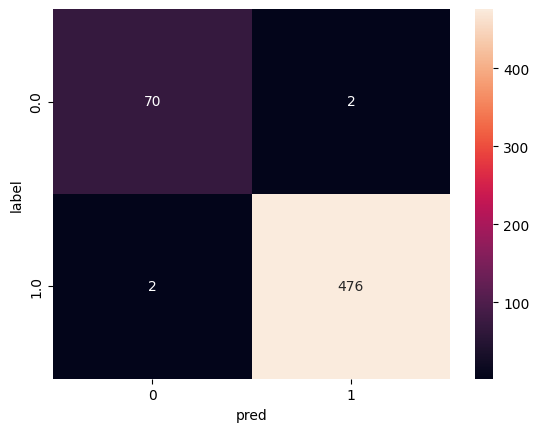

In [19]:
import seaborn as sns
df_confusion=classifier(sms_set,label_set)

ax= plt.subplot()
sns.heatmap(df_confusion, annot=True, fmt='g', ax=ax)

Now getting the histogram of the log odds score

In [20]:
df=pd.DataFrame(data={'sms':sms_set,'label':label_set})
df['score']=df.apply(lambda row: score(row.sms),axis=1)

ham=df.query("label=='ham'")
spam=df.query("label=='spam'")

Text(0.5, 0, 'Score')

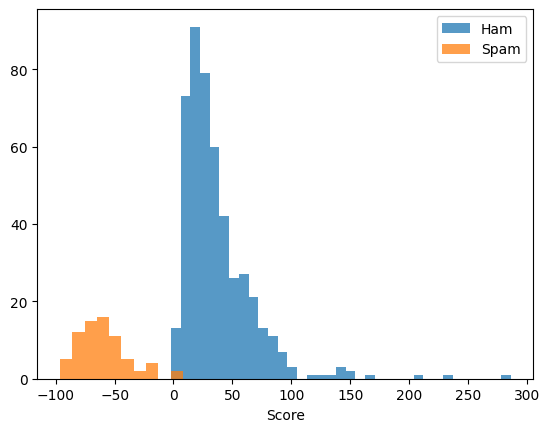

In [21]:
plt.hist(ham['score'],bins=35,alpha=0.75,label='Ham')
plt.hist(spam['score'],bins=10,alpha=0.75,label='Spam')
plt.legend()
plt.xlabel('Score')